In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os

In [ ]:
import torch.nn.functional as F
class FCN(nn.Module):
    def __init__(self, num_classes):
        super(FCN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.upsample = nn.ConvTranspose2d(128, num_classes, kernel_size=16, stride=8, padding=4)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = self.upsample(x)
        x = F.interpolate(x, size=(256, 256), mode='bilinear', align_corners=False)
        return x

class CustomDataset(Dataset):
    def __init__(self, image_dir, label_dir, transform=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transform = transform
        self.image_filenames = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]
        self.label_filenames = [f.replace('.jpg', '_mask.png') for f in self.image_filenames]

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.image_filenames[idx])
        label_name = os.path.join(self.label_dir, self.label_filenames[idx].replace('.jpg', '_mask.png'))

        image = Image.open(img_name).convert('RGB')
        label = Image.open(label_name).convert('L')  # Convert to grayscale
        
        if self.transform:
            image = self.transform(image)
            label = self.transform(label)
        
        # Convert label to LongTensor for CrossEntropyLoss
        label = torch.squeeze(label, 0).long()  # Remove channel dim and convert to long

        return image, label

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

image_dir = r"C:\Users\USER\OneDrive\바탕 화면\횡단보도\segmentation\images"
label_dir = r"C:\Users\USER\OneDrive\바탕 화면\횡단보도\segmentation\labels"
dataset = CustomDataset(image_dir, label_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

num_classes = 2
fcn_model = FCN(num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(fcn_model.parameters(), lr=0.001)

num_epochs = 10
for epoch in range(num_epochs):
    for images, labels in dataloader:
        optimizer.zero_grad()
        outputs = fcn_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

torch.save(fcn_model.state_dict(), 'fcn_model.pth')


Epoch [1/10], Loss: 0.0000
Epoch [2/10], Loss: 0.0000
Epoch [3/10], Loss: 0.0000
Epoch [4/10], Loss: 0.0000
Epoch [5/10], Loss: 0.0000
Epoch [6/10], Loss: 0.0000


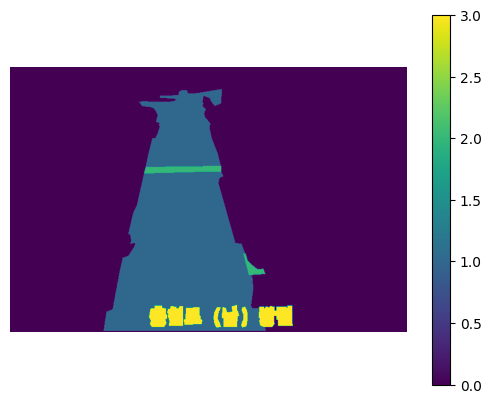

In [6]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# 라벨 이미지를 불러옵니다
label_path = r"C:\Users\USER\OneDrive\바탕 화면\횡단보도\segmentation\labels\CC1522002_2023-06-23-034657_mask.png"
label_image = Image.open(label_path)

# 이미지를 numpy 배열로 변환합니다
label_array = np.array(label_image)

# Plot the image using a colormap that can display 4 different values distinctly
plt.imshow(label_array, cmap='viridis')  # 'viridis' 컬러맵을 사용합니다
plt.colorbar()  # 컬러바를 표시하여 각 색상이 어떤 값을 나타내는지 표시합니다
plt.axis('off')  # 축을 숨깁니다
plt.show()
